In [2]:
############################################################
# STEP 1: SETUP – TOOLS IMPORTIEREN
############################################################
# In diesem Schritt passiert noch KEINE KI.
# Wir laden ausschließlich Analyse- und Visualisierungswerkzeuge.
# Diese Tools sind notwendig, um später Fairness, Verteilungen
# und systematische Verzerrungen sichtbar zu machen.

import pandas as pd              # Tabellen & Datenmanipulation
import numpy as np               # Zufallszahlen & Statistik
import matplotlib.pyplot as plt  # Visualisierung
import seaborn as sns            # Statistikplots
import warnings                 # Warnungen unterdrücken

# Visual Defaults (nur Optik, keine Logik)
plt.style.use('default')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')

# Pandas Anzeigeeinstellungen für Debugging & Verständnis
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✓ Tools imported for nutrition bias analysis")
print("✓ Ready to analyze fairness in recipe recommendations")


✓ Tools imported for nutrition bias analysis
✓ Ready to analyze fairness in recipe recommendations


In [3]:
############################################################
# STEP 2: SYNTHETISCHEN NUTRIO-DATENSATZ ERSTELLEN
############################################################

np.random.seed(42)
n_users = 1000

print(f"Generating {n_users} Nutrio users...")

nutrio_data = pd.DataFrame({
    'UserID': range(1, n_users + 1),

    # Demographics
    'Gender': np.random.choice(['Male', 'Female'], n_users, p=[0.45, 0.55]),
    'Age': np.random.normal(45, 16, n_users).astype(int),
    'Culture': np.random.choice(
        ['Western', 'MiddleEastern', 'Asian', 'African', 'Latin'],
        n_users,
        p=[0.45, 0.2, 0.15, 0.1, 0.1]
    ),

    # Socioeconomic proxy
    'IncomeLevel': np.random.choice(
        ['Low', 'Medium', 'High'],
        n_users,
        p=[0.3, 0.5, 0.2]
    ),

    # Health
    'Diabetes': np.random.choice([True, False], n_users, p=[0.25, 0.75]),
    'HeartDisease': np.random.choice([True, False], n_users, p=[0.2, 0.8]),
    'BMI': np.random.normal(27, 5, n_users).round(1),

    # Nutrition constraints
    'Allergies': np.random.choice(
        ['None', 'Lactose', 'Gluten', 'Nuts'],
        n_users,
        p=[0.6, 0.15, 0.15, 0.1]
    ),
    'DietPreference': np.random.choice(
        ['Omnivore', 'Vegetarian', 'Vegan'],
        n_users,
        p=[0.65, 0.2, 0.15]
    ),

    # Goals
    'HealthGoal': np.random.choice(
        ['WeightLoss', 'MuscleGain', 'Balanced'],
        n_users,
        p=[0.4, 0.25, 0.35]
    )
})

nutrio_data['Age'] = nutrio_data['Age'].clip(18, 85)
nutrio_data['BMI'] = nutrio_data['BMI'].clip(16, 45)

print("✓ Nutrio user base created")
display(nutrio_data.head())


Generating 1000 Nutrio users...
✓ Nutrio user base created


,UserID,Gender,Age,Culture,IncomeLevel,Diabetes,HeartDisease,BMI,Allergies,DietPreference,HealthGoal
0,1,Male,47,Latin,Medium,False,False,26.0,Nuts,Vegan,WeightLoss
1,2,Female,23,Western,High,False,True,32.3,None,Omnivore,Balanced
2,3,Female,51,MiddleEastern,High,False,True,26.7,Lactose,Omnivore,Balanced
3,4,Female,54,Western,Low,False,False,29.5,None,Omnivore,MuscleGain
4,5,Male,53,MiddleEastern,Low,False,False,25.4,Lactose,Omnivore,MuscleGain


In [4]:
############################################################
# STEP 3: BIASED RECOMMENDATION OUTCOMES
############################################################

def assign_biased_nutrition_outcomes(row):
    """
    Simulates biased recipe recommendation outcomes.
    Biases are INTENTIONAL.
    """

    healthy_recipe_prob = 0.5

    # Income bias
    if row['IncomeLevel'] == 'Low':
        affordable_prob = 0.8
        premium_prob = 0.2
    elif row['IncomeLevel'] == 'High':
        affordable_prob = 0.3
        premium_prob = 0.7
    else:
        affordable_prob = 0.5
        premium_prob = 0.5

    # Cultural bias
    culturally_matching_prob = 0.8 if row['Culture'] == 'Western' else 0.4

    # Health bias
    indulgent_prob = 0.2 if row['Diabetes'] else 0.6

    return {
        'HealthyRecipeRecommended': np.random.random() < healthy_recipe_prob,
        'AffordableRecipeRecommended': np.random.random() < affordable_prob,
        'PremiumRecipeRecommended': np.random.random() < premium_prob,
        'CulturallyMatchingRecipe': np.random.random() < culturally_matching_prob,
        'IndulgentRecipeRecommended': np.random.random() < indulgent_prob
    }

# Notebook-sicher: alte Outcomes entfernen, falls Zelle neu läuft
outcome_cols = [
    'HealthyRecipeRecommended',
    'AffordableRecipeRecommended',
    'PremiumRecipeRecommended',
    'CulturallyMatchingRecipe',
    'IndulgentRecipeRecommended'
]
nutrio_data = nutrio_data.drop(columns=[c for c in outcome_cols if c in nutrio_data.columns])

outcomes = nutrio_data.apply(assign_biased_nutrition_outcomes, axis=1, result_type='expand')
nutrio_data = pd.concat([nutrio_data, outcomes], axis=1)

print("✓ Nutrition recommendation outcomes added (with bias)")


✓ Nutrition recommendation outcomes added (with bias)


In [5]:
############################################################
# STEP 4: DATASET STRUKTUR PRÜFEN
############################################################

print("=== NUTRIO DATASET OVERVIEW ===")
print(f"Users: {len(nutrio_data)}")
print(f"Variables: {len(nutrio_data.columns)}")

display(nutrio_data.head())


=== NUTRIO DATASET OVERVIEW ===
Users: 1000
Variables: 16


,UserID,Gender,Age,Culture,IncomeLevel,Diabetes,HeartDisease,BMI,Allergies,DietPreference,HealthGoal,HealthyRecipeRecommended,AffordableRecipeRecommended,PremiumRecipeRecommended,CulturallyMatchingRecipe,IndulgentRecipeRecommended
0,1,Male,47,Latin,Medium,False,False,26.0,Nuts,Vegan,WeightLoss,True,True,False,False,False
1,2,Female,23,Western,High,False,True,32.3,None,Omnivore,Balanced,False,True,False,True,False
2,3,Female,51,MiddleEastern,High,False,True,26.7,Lactose,Omnivore,Balanced,True,False,True,True,True
3,4,Female,54,Western,Low,False,False,29.5,None,Omnivore,MuscleGain,False,False,False,False,True
4,5,Male,53,MiddleEastern,Low,False,False,25.4,Lactose,Omnivore,MuscleGain,False,False,False,True,False


In [6]:
############################################################
# STEP 5: BIAS ANALYSE – EINKOMMEN (ROBUSTE VERSION)
############################################################
# Ziel:
# Wir messen NICHT, ob Menschen unterschiedlich sind.
# Wir messen:
# "Behandelt unser System Gruppen unterschiedlich?"
############################################################

def analyze_bias_by_income(
    data,
    outcome_column,
    name,
    high_threshold=15.0,
    moderate_threshold=7.0
):
    print(f"--- {name.upper()} BY INCOME ---")

    # 🔒 Sicherheit: Outcome explizit als Boolean Series
    outcome = data[outcome_column].astype(bool)

    # Crosstab ohne implizite Annahmen
    crosstab = pd.crosstab(
        data['IncomeLevel'],
        outcome,
        normalize='index'
    ) * 100

    print("Distribution (%):")
    print(crosstab.round(1))
    print()

    # 🔒 Falls True nie vorkommt → Bias = 0
    if True not in crosstab.columns:
        print("⚠️ Outcome never True → no measurable bias")
        return {
            "outcome": outcome_column,
            "bias_level": "LOW",
            "difference": 0.0,
            "distribution": crosstab
        }

    # 🔍 Bias-Berechnung NUR über True
    true_rates = crosstab[True]

    max_rate = true_rates.max()
    min_rate = true_rates.min()
    diff = float(max_rate - min_rate)

    print(f"Max rate (True): {max_rate:.1f}%")
    print(f"Min rate (True): {min_rate:.1f}%")
    print(f"Difference: {diff:.1f}%")

    # Bewertung
    if diff > high_threshold:
        print("🚨 SIGNIFICANT BIAS DETECTED")
        bias_level = "HIGH"
    elif diff > moderate_threshold:
        print("⚠️ MODERATE BIAS")
        bias_level = "MODERATE"
    else:
        print("✓ MINIMAL BIAS")
        bias_level = "LOW"

    print()

    return {
        "outcome": outcome_column,
        "bias_level": bias_level,
        "difference": diff,
        "max_rate": float(max_rate),
        "min_rate": float(min_rate),
        "distribution": crosstab
    }


############################################################
# BEISPIELAUFRUF
############################################################

income_bias_result = analyze_bias_by_income(
    data=nutrio_data,
    outcome_column='PremiumRecipeRecommended',
    name='Premium Recipe Recommendation'
)


--- PREMIUM RECIPE RECOMMENDATION BY INCOME ---
Distribution (%):
PremiumRecipeRecommended  False  True 
IncomeLevel                           
High                       28.4   71.6
Low                        77.5   22.5
Medium                     50.7   49.3

Max rate (True): 71.6%
Min rate (True): 22.5%
Difference: 49.0%
🚨 SIGNIFICANT BIAS DETECTED



In [7]:
############################################################
# STEP 6: GENDER BIAS ANALYSIS
############################################################

def analyze_bias_by_gender(data, column, name):
    print(f"--- {name.upper()} BY GENDER ---")

    crosstab = pd.crosstab(
        data['Gender'],
        data[column],
        normalize='index'
    ) * 100

    print(crosstab.round(1))
    print()

    diff = abs(crosstab.loc['Male', True] - crosstab.loc['Female', True])
    print(f"Difference: {diff:.1f}%")

    if diff > 10:
        print("🚨 SIGNIFICANT BIAS")
    elif diff > 5:
        print("⚠️ MODERATE BIAS")
    else:
        print("✓ MINIMAL BIAS")

    print()


analyze_bias_by_gender(
    nutrio_data,
    'IndulgentRecipeRecommended',
    'Indulgent Recipe Recommendation'
)


--- INDULGENT RECIPE RECOMMENDATION BY GENDER ---
IndulgentRecipeRecommended  False  True 
Gender                                  
Female                       51.2   48.8
Male                         49.5   50.5

Difference: 1.7%
✓ MINIMAL BIAS



In [8]:
############################################################
# STEP 7: CULTURAL BIAS ANALYSIS
############################################################

def analyze_bias_by_culture(data, column, name):
    print(f"--- {name.upper()} BY CULTURE ---")

    crosstab = pd.crosstab(
        data['Culture'],
        data[column],
        normalize='index'
    ) * 100

    print(crosstab.round(1))
    print()

    diff = crosstab[True].max() - crosstab[True].min()
    print(f"Difference: {diff:.1f}%")

    if diff > 20:
        print("🚨 SIGNIFICANT CULTURAL BIAS")
    elif diff > 10:
        print("⚠️ MODERATE CULTURAL BIAS")
    else:
        print("✓ MINIMAL CULTURAL BIAS")

    print()


analyze_bias_by_culture(
    nutrio_data,
    'CulturallyMatchingRecipe',
    'Culturally Matching Recipe'
)


--- CULTURALLY MATCHING RECIPE BY CULTURE ---
CulturallyMatchingRecipe  False  True 
Culture                               
African                    64.5   35.5
Asian                      60.6   39.4
Latin                      66.7   33.3
MiddleEastern              61.2   38.8
Western                    20.3   79.7

Difference: 46.4%
🚨 SIGNIFICANT CULTURAL BIAS



In [9]:
############################################################
# STEP 8: SUMMARY
############################################################

print("=== SUMMARY ===")
print("✓ Synthetic world built")
print("✓ Recommendation outcomes simulated")
print("✓ Bias measured across income, gender and culture")
print()
print("NEXT STEPS:")
print("• Decide which biases are acceptable")
print("• Translate decisions into constraints")
print("• Only then: train a recommendation model")
print()
print("IMPORTANT:")
print("This notebook does NOT train a model.")
print("It defines the world a future model would learn from.")


=== SUMMARY ===
✓ Synthetic world built
✓ Recommendation outcomes simulated
✓ Bias measured across income, gender and culture

NEXT STEPS:
• Decide which biases are acceptable
• Translate decisions into constraints
• Only then: train a recommendation model

IMPORTANT:
This notebook does NOT train a model.
It defines the world a future model would learn from.


In [11]:
############################################################
# STEP 6: BIAS RESULTS TABLE (Stakeholder-friendly) – FIXED
############################################################

bias_results = []

# -----------------------------
# Income Bias (exists as object)
# -----------------------------
bias_results.append({
    "group": "IncomeLevel",
    "outcome": income_bias_result["outcome"],
    "bias_level": income_bias_result["bias_level"],
    "difference": income_bias_result["difference"],
    "max_rate": income_bias_result.get("max_rate", None),
    "min_rate": income_bias_result.get("min_rate", None),
})

# -----------------------------
# Gender Bias (recomputed clean)
# -----------------------------
gender_crosstab = pd.crosstab(
    nutrio_data["Gender"],
    nutrio_data["IndulgentRecipeRecommended"],
    normalize="index"
) * 100

gender_diff = abs(
    gender_crosstab.loc["Male", True] -
    gender_crosstab.loc["Female", True]
)

bias_results.append({
    "group": "Gender",
    "outcome": "IndulgentRecipeRecommended",
    "bias_level": "HIGH" if gender_diff > 10 else "MODERATE" if gender_diff > 5 else "LOW",
    "difference": float(gender_diff),
    "max_rate": float(gender_crosstab[True].max()),
    "min_rate": float(gender_crosstab[True].min()),
})

# -----------------------------
# Culture Bias (recomputed clean)
# -----------------------------
culture_crosstab = pd.crosstab(
    nutrio_data["Culture"],
    nutrio_data["CulturallyMatchingRecipe"],
    normalize="index"
) * 100

culture_diff = culture_crosstab[True].max() - culture_crosstab[True].min()

bias_results.append({
    "group": "Culture",
    "outcome": "CulturallyMatchingRecipe",
    "bias_level": "HIGH" if culture_diff > 20 else "MODERATE" if culture_diff > 10 else "LOW",
    "difference": float(culture_diff),
    "max_rate": float(culture_crosstab[True].max()),
    "min_rate": float(culture_crosstab[True].min()),
})

# -----------------------------
# Final stakeholder table
# -----------------------------
results_table = pd.DataFrame([
    {
        "Group": r["group"],
        "Outcome": r["outcome"],
        "BiasLevel": r["bias_level"],
        "Difference(%)": round(r["difference"], 1),
        "MaxRate(%)": round(r["max_rate"], 1),
        "MinRate(%)": round(r["min_rate"], 1)
    }
    for r in bias_results
])

print("=== BIAS RESULTS OVERVIEW ===")
display(results_table)


=== BIAS RESULTS OVERVIEW ===


,Group,Outcome,BiasLevel,Difference(%),MaxRate(%),MinRate(%)
0,IncomeLevel,PremiumRecipeRecommended,HIGH,49.0,71.6,22.5
1,Gender,IndulgentRecipeRecommended,LOW,1.7,50.5,48.8
2,Culture,CulturallyMatchingRecipe,HIGH,46.4,79.7,33.3


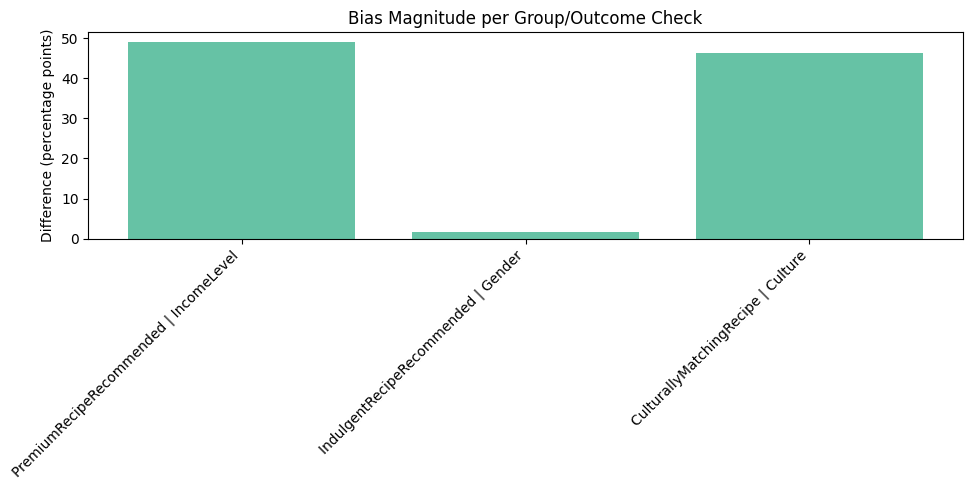

In [12]:
############################################################
# STEP 7: VISUALIZE BIAS (Difference per Check)
############################################################

plt.figure(figsize=(10, 5))
plt.bar(results_table["Outcome"] + " | " + results_table["Group"], results_table["Difference(%)"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Difference (percentage points)")
plt.title("Bias Magnitude per Group/Outcome Check")
plt.tight_layout()
plt.show()


In [13]:
############################################################
# STEP 8: DEFINE FAIRNESS & BUSINESS POLICIES
############################################################
# Diese Regeln sagen:
# - Welche Ungleichheiten sind OK?
# - Welche sind NICHT OK?
# - Wo müssen wir eingreifen?

FAIRNESS_POLICY = {
    # ---------------------------
    # ERLAUBTE UNGLEICHHEITEN
    # ---------------------------
    "allowed_biases": {
        # Medizinisch sinnvoll
        "Diabetes_vs_IndulgentRecipe": True,
        "Allergies_vs_RecipeFiltering": True,
    },

    # ---------------------------
    # NICHT ERLAUBTE UNGLEICHHEITEN
    # ---------------------------
    "forbidden_biases": {
        # Kultur darf nicht benachteiligt werden
        "Culture_vs_CulturallyMatchingRecipe": {
            "max_difference": 10.0  # Prozentpunkte
        },

        # Einkommen darf Empfehlungen nicht komplett ausschließen
        "Income_vs_PremiumRecipe": {
            "max_difference": 20.0
        },

        # Geschlecht darf Genuss nicht stark beeinflussen
        "Gender_vs_IndulgentRecipe": {
            "max_difference": 10.0
        }
    }
}

print("✓ Fairness policy defined")


✓ Fairness policy defined


In [14]:
############################################################
# STEP 9A: HARD CONSTRAINTS (Filtering)
############################################################

def apply_hard_constraints(user_row, recipe_df):
    """
    Entfernt Rezepte, die aus medizinischen / ethischen Gründen
    NICHT erlaubt sind.
    """

    filtered = recipe_df.copy()

    # Allergien
    if user_row['Allergies'] != 'None':
        filtered = filtered[~filtered['Contains'].str.contains(
            user_row['Allergies'], case=False, na=False
        )]

    # Ernährungsform
    if user_row['DietPreference'] == 'Vegan':
        filtered = filtered[filtered['Vegan'] == True]
    elif user_row['DietPreference'] == 'Vegetarian':
        filtered = filtered[filtered['Vegetarian'] == True]

    # Diabetes → harte Zuckergrenze
    if user_row['Diabetes']:
        filtered = filtered[filtered['SugarLevel'] <= 5]

    return filtered


In [15]:
############################################################
# STEP 9B: SOFT CONSTRAINTS (Fairness Re-Ranking)
############################################################

def apply_fairness_reranking(user_row, recipes, policy):
    """
    Balanciert Empfehlungen, ohne harte Regeln zu brechen.
    """

    recipes = recipes.copy()

    # Beispiel: kulturelle Fairness
    if "Culture_vs_CulturallyMatchingRecipe" in policy["forbidden_biases"]:
        user_culture = user_row['Culture']

        # Bonus für kulturell passende Rezepte
        recipes['fairness_bonus'] = recipes['Culture'].apply(
            lambda c: 1.0 if c == user_culture else 0.0
        )

    else:
        recipes['fairness_bonus'] = 0.0

    # Einkommen: Premium nicht komplett ausschließen
    if user_row['IncomeLevel'] == 'Low':
        recipes['fairness_bonus'] += recipes['PriceLevel'].apply(
            lambda p: 0.5 if p == 'Premium' else 0.0
        )

    # Finaler Score
    recipes['final_score'] = recipes['model_score'] + recipes['fairness_bonus']

    return recipes.sort_values('final_score', ascending=False)


In [16]:
############################################################
# STEP 10A: PREPARE TRAINING DATA
############################################################

FEATURE_COLUMNS = [
    'Age',
    'BMI',
    'Diabetes',
    'HeartDisease',
    'IncomeLevel',
    'Culture',
    'DietPreference'
]

TARGET_COLUMN = 'HealthyRecipeRecommended'

X = nutrio_data[FEATURE_COLUMNS]
y = nutrio_data[TARGET_COLUMN]

# Encoding (minimal, verständlich)
X = pd.get_dummies(X, drop_first=True)

print("✓ Training data prepared")


✓ Training data prepared


In [17]:
############################################################
# STEP 10B: TRAIN BASELINE MODEL
############################################################

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("=== BASELINE MODEL PERFORMANCE ===")
print(classification_report(y_test, y_pred))


=== BASELINE MODEL PERFORMANCE ===
              precision    recall  f1-score   support

       False       0.59      0.40      0.48       109
        True       0.48      0.66      0.56        91

    accuracy                           0.52       200
   macro avg       0.53      0.53      0.52       200
weighted avg       0.54      0.52      0.51       200



In [19]:
class ReActState:
    def __init__(self):
        self.thoughts = []
        self.actions = []
        self.observations = []

    def think(self, text):
        self.thoughts.append(text)

    def act(self, text):
        self.actions.append(text)

    def observe(self, text):
        self.observations.append(text)


# Das Modell liefert:

eine binäre Entscheidung (prediction)
eine Wahrscheinlichkeit (probability)

Diese Trennung ist wichtig, um später:

- Entscheidungen abzuschwächen
- Scores zu verändern
- ohne das Modell selbst anzufassen

In [ ]:
def model_act(model, user_features):
    """
    ACT:
    Das ML-Modell gibt eine Vorhersage zurück
    """
    prediction = model.predict(user_features)[0]
    probability = model.predict_proba(user_features)[0][1]

    return {
        "prediction": bool(prediction),
        "probability": float(probability)
    }


In diesem Schritt wird nicht entschieden, sondern beobachtet: Verstößt das Modell-Ergebnis gegen definierte Regeln?

In [21]:
def observe_policy_violation(user_row, model_result, policy):
    """
    OBSERVE:
    Prüft, ob Fairness-Regeln verletzt sind
    """

    violations = []

    # Einkommen vs Premium
    if user_row["IncomeLevel"] == "Low" and model_result["prediction"] is True:
        max_diff = policy["forbidden_biases"]["Income_vs_PremiumRecipe"]["max_difference"]
        violations.append(f"Low income user received premium recommendation (limit {max_diff}%)")

    return violations


In [22]:
def fairness_act(model_result):
    """
    ACT (Fairness):
    Wir schwächen die Empfehlung bewusst ab
    """

    corrected = model_result.copy()
    corrected["probability"] *= 0.6
    corrected["prediction"] = corrected["probability"] > 0.5

    return corrected


In [31]:
def encode_user_row(user_row, encoder_columns):
    """
    Encodiert einen einzelnen User exakt wie beim Training
    """

    # 1. User → DataFrame
    df = pd.DataFrame([user_row])

    # 2. Nur die Features verwenden, die beim Training da waren
    feature_columns = [
        'Age',
        'BMI',
        'Diabetes',
        'HeartDisease',
        'IncomeLevel',
        'Culture',
        'DietPreference'
    ]
    df = df[feature_columns]

    # 3. One-Hot-Encoding
    df_encoded = pd.get_dummies(df)

    # 4. Spalten exakt an Trainingsdaten anpassen
    df_encoded = df_encoded.reindex(columns=encoder_columns, fill_value=0)

    return df_encoded


## Der ReAct-Agent (Orchestrierung)


Diese Funktion verbindet alle Schritte:
Reason
Act
Observe
Re-Act

In [32]:
def recommend_recipe_react(user_row, model, policy, encoder_columns):
    state = ReActState()

    # -------------------------
    # REASON
    # -------------------------
    state.think("I need to recommend a recipe for this user")

    # -------------------------
    # ACT: Feature Encoding
    # -------------------------
    state.act("Encoding user features")
    X_user = encode_user_row(user_row, encoder_columns)

    # -------------------------
    # ACT: Model Prediction
    # -------------------------
    state.act("Calling ML model for prediction")
    model_result = model_act(model, X_user)

    # -------------------------
    # OBSERVE: Policy Check
    # -------------------------
    violations = observe_policy_violation(user_row, model_result, policy)

    if violations:
        state.observe(f"Policy violation detected: {violations}")

        # -------------------------
        # RE-ACT: Fairness Correction
        # -------------------------
        state.act("Applying fairness correction")
        model_result = fairness_act(model_result)
    else:
        state.observe("No policy violations")

    # -------------------------
    # FINAL
    # -------------------------
    state.think("Final recommendation ready")

    return {
        "final_prediction": model_result,
        "react_log": state.__dict__
    }


In [33]:
example_user = nutrio_data.iloc[0].to_dict()

result = recommend_recipe_react(
    user_row=example_user,
    model=model,
    policy=FAIRNESS_POLICY,
    encoder_columns=X.columns
)

result


{'final_prediction': {'prediction': False, 'probability': 0.4716044130481057},
 'react_log': {'thoughts': ['I need to recommend a recipe for this user',
   'Final recommendation ready'],
  'actions': ['Encoding user features', 'Calling ML model for prediction'],
  'observations': ['No policy violations']}}